In [1]:
import torch
print('torch.cuda.is_available(): {}'.format(torch.cuda.is_available()))
import numpy as np
from utils import make_imb_data, get_cifar10_test, plot_distribution
from models.wrn import WRN
from collections import Counter
import matplotlib.pyplot as plt

torch.cuda.is_available(): True


In [2]:
N_SAMPLES_PER_CLASS = make_imb_data(1250, 10, 100 ,False, False)
U_SAMPLES_PER_CLASS = make_imb_data(3 * 1250, 10, 100, False, False)
N_SAMPLES_PER_CLASS_T = torch.Tensor(N_SAMPLES_PER_CLASS)

train_labeled_set, train_unlabeled_set, test_set = get_cifar10_test('/home/apoorva/Datasets', N_SAMPLES_PER_CLASS
, U_SAMPLES_PER_CLASS)

max_num=1250
[1250, 749, 449, 269, 161, 96, 58, 34, 20, 12]
max_num=3750
[3750, 2248, 1347, 807, 484, 290, 174, 104, 62, 37]
Files already downloaded and verified
#Labeled: 3098 #Unlabeled: 12401


In [3]:
def create_model(ema=False):
    model = WRN(2, len(N_SAMPLES_PER_CLASS))
    model = model.cuda()

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

model = create_model()
ema_model = create_model(ema=True))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


[ 161.   34. 1250.    0.   58.  761.  449.   20.  269.   96.]


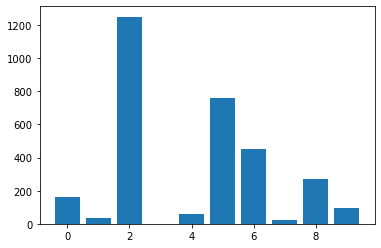

In [7]:
from sampler import UnlabeledDataLoader_test

list_dist = np.zeros(10)
# target_dist = torch.ones([10, 10])
# target_dist = torch.diag(torch.ones(10))
# target_dist = torch.ones([10, 10]) - torch.diag(torch.ones(10))
target_dist = torch.tensor([
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

labeled_loader = torch.utils.data.DataLoader(train_labeled_set, batch_size=128, num_workers=8, shuffle=True)
for imgs, lbls, _ in labeled_loader:
    ulb_loader = UnlabeledDataLoader_test(train_unlabeled_set, target_dist, N_SAMPLES_PER_CLASS, 128)
    img_u, ulb_u = ulb_loader.get_batch(lbls)
    ulb_u = ulb_u.numpy()
    for i in ulb_u:
        list_dist[i]+=1
print(list_dist)
plt.bar(np.arange(10), list_dist)
plt.savefig('images/off_diagonal.png')